In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
from skimage import measure

In [17]:
path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/2000/'

In [46]:
PW2000 = xr.open_mfdataset(path+'??PW.nc')

/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [47]:
PW2000

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 744)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-01-31T23:00:00
Data variables:
    tcwv       (time, latitude, longitude) float32 dask.array<shape=(744, 721, 1440), chunksize=(744, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-10-28 17:31:27 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

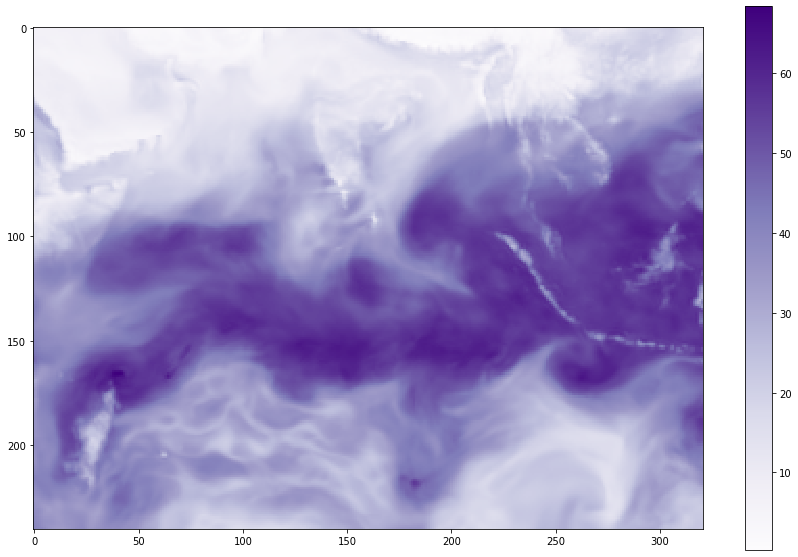

In [53]:
plt.figure(figsize=(15,10))

plt.imshow(PW2000.tcwv[0,:,:].sel({'latitude':slice(30,-30),'longitude':slice(40,120)}),cmap='Purples')
plt.colorbar()

In [49]:
def find_separation_bin(field,vmin=45,vmax=55,bins=100):
# Inputs
# field = field from which to take the pdf
# vmin = minimal value of the interval over which min(PDF) will be searched
# vmax = maximal value //
# bins = Number of bins of the PDF

    field_hist,bin_edges = np.histogram(field.flatten(),bins=bins)
    bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

    binary = (bin_mid<vmax)*(bin_mid>vmin)
    imin =  np.argmin(field_hist[binary])+np.argmax(binary)

    return bin_mid[imin],bin_mid

In [50]:
CWV_sep,bin_m = find_separation_bin(PW2000.tcwv[:24,:,:].sel({'latitude':slice(30,-30),'longitude':slice(260,360)}).values)

46.832926998138426


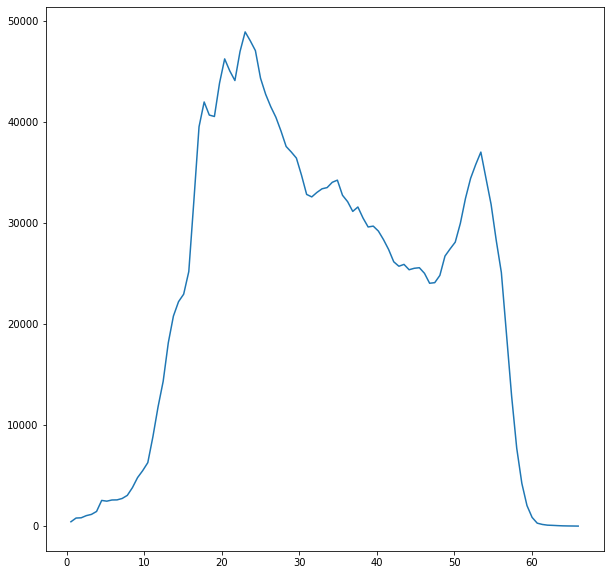

In [51]:
plt.figure(figsize=(10,10))
CWV_hist,bin_edges = np.histogram(PW2000.tcwv[:24,:,:].sel({'latitude':slice(30,-30),'longitude':slice(260,360)}).values.flatten(),\
                                  bins=100)
bin_m = 0.5*(bin_edges[:-1]+bin_edges[1:])
plt.plot(bin_m,CWV_hist)

imin_tmp = np.argmin(CWV_hist[(bin_m<55)*(bin_m>45)])
ileft = np.argmax((bin_m<55)*(bin_m>45))
imin = ileft+imin_tmp
print(bin_m[imin])

CWV_sep = bin_m[imin]

In [68]:
it = 0
CRH = PW2000.tcwv
contours = measure.find_contours(CRH[it,:,:],np.median(CRH[it,:,:]))

# 1) Global WindMiller Index

In [ ]:
# Average grid box area
Nx = PW2000.longitude.size
Ny = PW2000.latitude.size
A_earth = 510.1e6; # In km2
A_grid_avg = A_earth/(Nx*Ny)
dx_avg = np.sqrt(A_grid_avg)

In [ ]:
WMI = calc_WMI(PW2000.tcwv[::24,:,:]),\
               dx_avg,CWV_sep)

In [1]:
def calc_WMI(CRH,dx,CRH_sep=None, slices=3):
    ### Input: precipitable water field (time, x, y)
    ### dx = Average grid spacing
    ### CRH_sep = Value separating moist and dry regions
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    
    if CRH_sep==None: CRH_median = np.median(CRH, axis=(1,2))
    else: CRH_sep = np.expand_dims(CRH_sep,axis=0)
    print(CRH_sep.shape)
    tmp = np.repeat(CRH_sep[:, np.newaxis], CRH.shape[1], axis=1)
    CRH_median_rep = np.repeat(tmp[:,:,np.newaxis],CRH.shape[2],axis=2)
    
    binary = CRH>CRH_median_rep
    
    for s in slices:
        print(PW2000.tcwv)
    
    #Todo:For now only one slice, create loop 
    binary = binary.sel({'latitude':slice(30,-30),'longitude':slice(260,290)}
    
    #Extract only the boundary in the Y direction
    binary_boundary = binary.values
    binary_boundary[:,:,1:-2] = 0
    
    A_tot = np.sum(binary,axis=(1,2))*(dx**2)/1e12
    
    perimeter_tot = np.zeros(CRH.shape[0])
    
    for it in range(len(np.median(CRH,axis=(1,2)))):
        print("calculating time step %i"%it)
        perimeter_tot[it] = dx*(measure.perimeter(binary[it,:,:],8) - measure.perimeter(binary_boundary[it,:,:])/2)/1e6

    WMI = 4*np.pi*A_tot/perimeter_tot**2
    
    return WMI

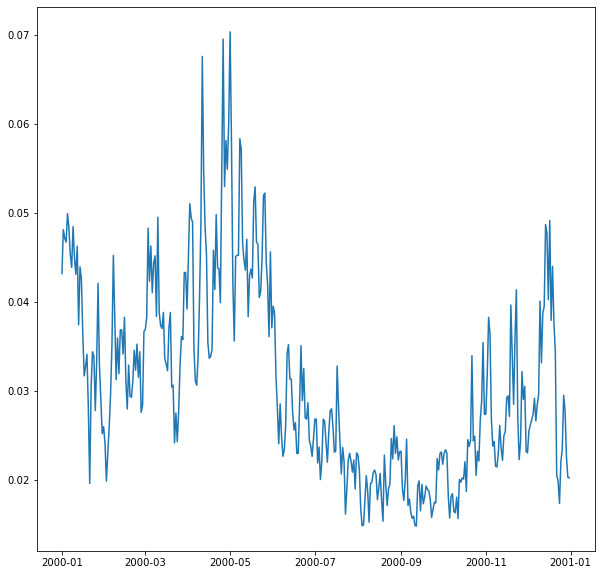

In [101]:
plt.figure(figsize=(10,10))

plt.plot(PW2000.time[::24],WMI)

# 2) Regional WindMiller Index